# Homework #3

In [4]:
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import cv2
import pandas as pd
from PIL import Image

import theano
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras import regularizers
from keras.utils import np_utils

# Size the plot appropriately for online display
plt.rcParams['figure.figsize'] = (16.0, 12.0)

nr.seed(3244)

x_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('X_test.npy')


def imageResize(img):
    return cv2.resize(img, (0,0), fx=3, fy=3)

# Reshape
x_train_reshaped = x_train.reshape(x_train.shape[0], 50, 37)
x_test_reshaped = x_test.reshape(x_test.shape[0], 50, 37)

# Resize
X_train = np.asarray(list(map(imageResize, x_train_reshaped)))
X_test = np.asarray(list(map(imageResize, x_test_reshaped)))

N, HEIGHT, WIDTH = X_train.shape

Using TensorFlow backend.


In [3]:
# Format output file
def reformatOutput(y_test):
    df = pd.DataFrame(y_test,columns=['PredictedClass'])
    df['Imageid']=np.arange(len(df))
    df.to_csv('pred.csv',index=False)

In [4]:
def imageFilter(img, kernel):
    kernel = np.array(kernel,np.int32)/25
    return cv2.filter2D(img,-1,kernel)

In [5]:
def gaussianBlur(img):
    return cv2.GaussianBlur(img,(5,5),0)

In [6]:
def sharpen(img):
    kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]],np.int32)/25
    return cv2.filter2D(img,-1,kernel)

In [7]:
def unsharpMask(img):
    gaussian_3 = cv2.GaussianBlur(img, (9,9), 10.0)
    return cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)

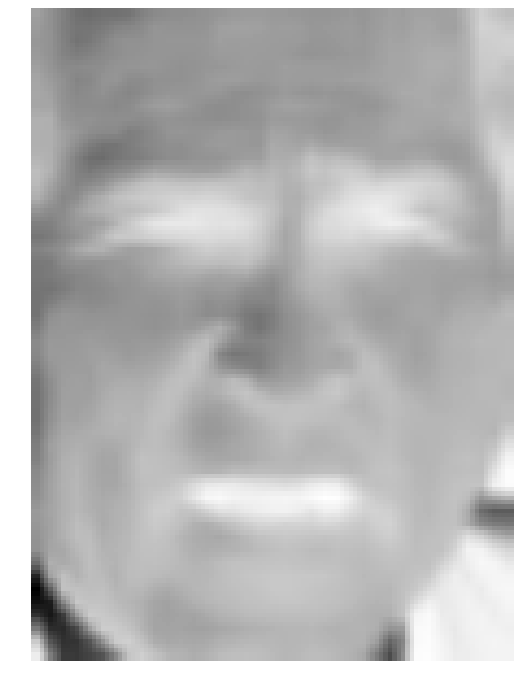

In [8]:
testImg = X_train[543]
plt.axis('off')
plt.imshow(testImg)

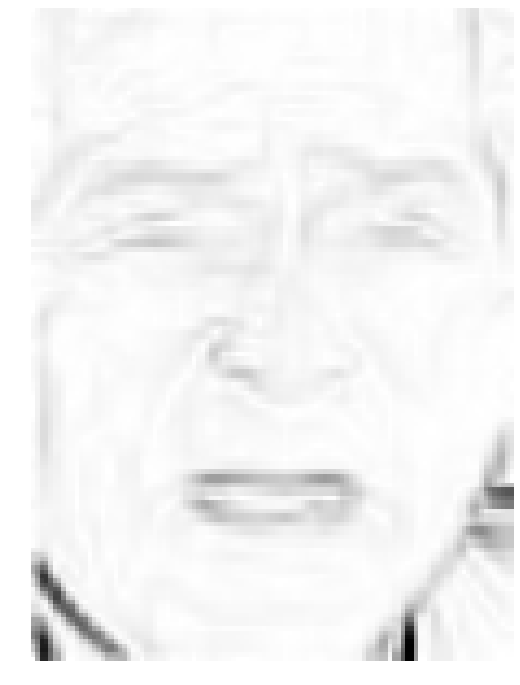

In [9]:
# Sobel Filter

def newSobelFilter(imageArray):
    sobelUp = imageFilter(imageArray, [[3,10,3],[0,0,0],[-3,-10,-3]])
    sobelDown = imageFilter(imageArray, [[-3,-10,-3],[0,0,0],[3,10,3]])
    sobelLeft = imageFilter(imageArray, [[3,0,-3],[10,0,-10],[3,0,-3]])
    sobelRight = imageFilter(imageArray, [[-3,0,3],[-10,0,10],[-3,0,3]])
    
    sobel = np.empty([HEIGHT, WIDTH])
    for i in range (0, HEIGHT):
        for j in range (0, WIDTH):
            sobel[i][j] = (sobelUp[i][j]**2 + sobelDown[i][j]**2 + sobelLeft[i][j]**2 + sobelRight[i][j]**2)**(1/2)
            
    return sobel

sobel = newSobelFilter(testImg)
plt.axis('off')
plt.imshow(sobel)

In [10]:
# Sobel Filter
import math

def sobelFilter(imageArray):
    sobelx = cv2.Sobel(imageArray,cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(imageArray,cv2.CV_64F,0,1,ksize=3)
    sobel = np.empty([HEIGHT, WIDTH, 2])
    for i in range (0, HEIGHT):
        for j in range (0, WIDTH):
            sobel[i][j][0] = (sobelx[i][j]**2 + sobely[i][j]**2)**(1/2)
            sobel[i][j][1] = np.arctan(sobely[i][j] / sobelx[i][j])
            if math.isnan(sobel[i][j][1]): sobel[i][j][1] = 0
    return sobel

sobel = sobelFilter(testImg)
# plt.axis('off')
# plt.imshow(sobel)

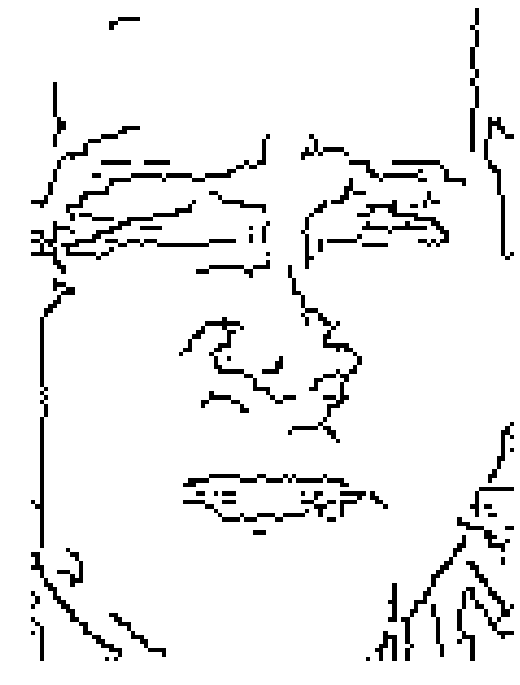

In [11]:
# canny Filter

def cannyFilter(imageArray):
    imageArrayCopy = np.uint8(imageArray)
    img = cv2.Canny(imageArrayCopy,10,50)
    
    return img

img = cannyFilter(testImg)
plt.axis('off')
plt.imshow(img)

# VANILLA IMAGES

In [126]:
# Reshape to 1 dimension
X_train_vanilla = X_train.reshape(X_train.shape[0], HEIGHT, WIDTH, 1)
X_test_vanilla = X_test.reshape(X_test.shape[0], HEIGHT, WIDTH, 1)

# Normalize
X_train_vanilla = X_train_vanilla.astype('float32')
X_test_vanilla = X_test_vanilla.astype('float32')
X_train_vanilla /= 255
X_test_vanilla /= 255

# Change to categorical matrix
Y_train_vanilla = np_utils.to_categorical(y_train, 7)

# Declare Sequential model
model = Sequential()

# CNN model architecture
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(HEIGHT, WIDTH, 1)))
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(7, activation='softmax'))

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit model
model.fit(X_train_vanilla, Y_train,
          validation_split=0.5, shuffle=True,
          batch_size=42, epochs=10, verbose=1)

Train on 483 samples, validate on 483 samples
Epoch 1/10
483/483 [==============================] - 60s - loss: 0.4790 - acc: 0.8444 - val_loss: 0.3711 - val_acc: 0.8571
Epoch 2/10
483/483 [==============================] - 47s - loss: 0.3838 - acc: 0.8563 - val_loss: 0.3652 - val_acc: 0.8571
Epoch 3/10
483/483 [==============================] - 48s - loss: 0.3778 - acc: 0.8536 - val_loss: 0.3731 - val_acc: 0.8571
Epoch 4/10
483/483 [==============================] - 51s - loss: 0.3771 - acc: 0.8560 - val_loss: 0.3635 - val_acc: 0.8571
Epoch 5/10
483/483 [==============================] - 53s - loss: 0.3683 - acc: 0.8560 - val_loss: 0.3618 - val_acc: 0.8571
Epoch 6/10
483/483 [==============================] - 53s - loss: 0.3734 - acc: 0.8545 - val_loss: 0.3598 - val_acc: 0.8574
Epoch 7/10
483/483 [==============================] - 53s - loss: 0.3609 - acc: 0.8580 - val_loss: 0.3539 - val_acc: 0.8634
Epoch 8/10
483/483 [==============================] - 53s - loss: 0.3538 - acc: 0.8645

In [610]:
# Evaluate train data
score = model.evaluate(X_train_vanilla, Y_train, verbose=1)
print()
print(score)

960/966 [============================>.] - ETA: 0s
[0.00015169508422079676, 1.0]


In [611]:
# Predict test data
prediction = model.predict(X_test_vanilla, verbose=1)
print(prediction)

320/322 [============================>.] - ETA: 0s[[  1.10274535e-02   3.35691991e-04   9.41707313e-01 ...,   3.41352541e-04
    1.41093304e-04   2.29428243e-03]
 [  1.84432645e-06   2.61472496e-06   1.28628317e-08 ...,   1.32235344e-02
    1.08001895e-01   4.26946549e-08]
 [  1.01429926e-07   6.37221717e-07   8.77063115e-08 ...,   1.01201190e-03
    1.43326237e-04   9.97705638e-01]
 ..., 
 [  1.13200602e-10   6.30679051e-11   3.73784758e-07 ...,   2.83952573e-09
    1.33169953e-09   1.73057835e-08]
 [  4.00029176e-16   9.02557143e-15   2.77871069e-13 ...,   3.82668420e-12
    6.33158526e-11   3.47529182e-14]
 [  7.89656429e-09   9.99740064e-01   3.47665119e-09 ...,   2.59970216e-06
    1.99996884e-06   7.80971959e-07]]


In [612]:
# Get output for test data
y_test = map(np.argmax, prediction)
y_test = np.asarray(list(y_test))
print(y_test)
print(y_test.shape)
np.savetxt("y_test.csv", y_test, delimiter=",")
reformatOutput(y_test)

[2 3 6 1 3 2 0 3 5 1 1 3 3 3 3 0 3 1 3 1 3 0 0 3 3 0 3 1 4 1 2 6 3 1 1 6 3
 6 3 6 3 6 3 1 3 3 2 3 3 3 3 3 3 3 4 3 1 5 4 0 6 4 2 3 4 3 1 3 3 3 3 3 3 3
 3 1 2 3 3 3 3 3 6 3 6 2 1 1 2 1 0 4 2 3 6 3 3 1 1 3 3 6 3 3 5 4 3 3 2 3 3
 3 0 5 3 3 6 5 2 3 2 1 5 3 6 3 3 4 2 4 3 3 3 1 5 3 1 2 3 3 1 6 1 3 3 1 3 2
 3 3 3 4 3 1 6 3 3 1 3 3 1 3 3 0 5 4 6 2 3 0 3 4 4 3 3 1 3 3 3 3 5 3 1 4 0
 6 3 1 3 5 1 5 2 3 3 3 2 3 1 4 3 2 3 3 3 2 3 3 1 4 0 6 3 6 3 1 3 2 3 3 1 6
 2 3 6 6 3 6 3 6 3 3 3 3 3 3 3 6 3 6 3 4 2 3 5 3 3 1 4 5 3 1 0 1 4 1 1 0 1
 2 3 1 3 3 3 3 3 1 3 6 1 3 4 3 3 3 6 1 1 1 3 3 3 6 4 3 0 3 3 3 3 5 6 3 6 3
 2 4 1 3 4 1 2 3 1 3 4 3 3 1 3 2 3 0 3 0 3 3 3 3 3 1]
(322,)


# APPLY SOBEL FILTER

In [3]:
# Filter all images
filtered_X_train = np.asarray(list(map(sobelFilter, X_train)))
filtered_X_test = np.asarray(list(map(sobelFilter, X_test)))

## Reshape to 1 dimension
X_train_sobel = filtered_X_train.reshape(X_train.shape[0], HEIGHT, WIDTH, 2)
X_test_sobel = filtered_X_test.reshape(X_test.shape[0], HEIGHT, WIDTH, 2)

# Normalize
X_train_sobel = X_train_sobel.astype('float32')
X_test_sobel = X_test_sobel.astype('float32')
X_train_sobel /= 255
X_test_sobel /= 255

# Change to categorical matrix
Y_train = np_utils.to_categorical(y_train, 7)

# Declare Sequential model
model = Sequential()

# CNN model architecture
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(HEIGHT, WIDTH, 2)))
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(8192, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(7, activation='softmax'))

NameError: name 'np' is not defined

In [2]:
model.summary()

NameError: name 'model' is not defined

In [1]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit model
# model.fit_generator(datagen.flow(X_train_sobel, Y_train, batch_size=32),
#                     steps_per_epoch=len(x_train) / 32, epochs=15)

model.fit(X_train_sobel, Y_train,
          validation_split=0.3, shuffle=True,
          batch_size=42, epochs=10, verbose=1)

NameError: name 'model' is not defined

In [ ]:
# Evaluate train data
score = model.evaluate(X_train_sobel, Y_train, verbose=1)
print()
print(score)

In [ ]:
# Predict test data
prediction = model.predict(X_test_sobel, verbose=1)
print(prediction)

In [ ]:
# Get output for test data
y_test = map(np.argmax, prediction)
y_test = np.asarray(list(y_test))
print(y_test)
print(y_test.shape)
reformatOutput(y_test)

In [433]:
# Filter all images
filtered_X_train = np.asarray(list(map(cannyFilter, X_train)))
filtered_X_test = np.asarray(list(map(cannyFilter, X_test)))

plt.imshow(filtered_X_train[0])

In [435]:
# Reshape to 1 dimension
X_train_canny = filtered_X_train.reshape(X_train.shape[0], HEIGHT, WIDTH, 1)
X_test_canny = filtered_X_test.reshape(X_test.shape[0], HEIGHT, WIDTH, 1)

# Normalize
X_train_canny = X_train_canny.astype('float32')
X_test_canny = X_test_canny.astype('float32')
X_train_canny /= 255
X_test_canny /= 255

# Change to categorical matrix
Y_train = np_utils.to_categorical(y_train, 7)

# Declare Sequential model
model = Sequential()

# CNN model architecture
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(HEIGHT, WIDTH, 1)))
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit model
model.fit(X_train_canny, Y_train, 
          batch_size=21, epochs=20, verbose=1)

Epoch 1/20
966/966 [==============================] - 8s - loss: 1.6653 - acc: 0.4037     
Epoch 2/20
966/966 [==============================] - 8s - loss: 1.2006 - acc: 0.5828     
Epoch 3/20
966/966 [==============================] - 9s - loss: 0.6775 - acc: 0.7598     
Epoch 4/20
966/966 [==============================] - 9s - loss: 0.3786 - acc: 0.8758     
Epoch 5/20
966/966 [==============================] - 10s - loss: 0.2314 - acc: 0.9234    
Epoch 6/20
966/966 [==============================] - 10s - loss: 0.1376 - acc: 0.9576    
Epoch 7/20
966/966 [==============================] - 11s - loss: 0.0976 - acc: 0.9710    
Epoch 8/20
966/966 [==============================] - 9s - loss: 0.0763 - acc: 0.9720     
Epoch 9/20
966/966 [==============================] - 8s - loss: 0.0680 - acc: 0.9824     
Epoch 10/20
966/966 [==============================] - 8s - loss: 0.0635 - acc: 0.9834     
Epoch 11/20
966/966 [==============================] - 8s - loss: 0.0461 - acc: 0.9876   

In [436]:
# Evaluate train data
score = model.evaluate(X_train_canny, Y_train, verbose=1)
print()
print(score)

960/966 [============================>.] - ETA: 0s
[9.4170089624691079e-05, 1.0]


In [437]:
# Predict test data
prediction = model.predict(X_test_canny, verbose=1)
print(prediction)

320/322 [============================>.] - ETA: 0s[[  2.43690722e-02   6.16770744e-01   3.31930518e-01 ...,   9.33662755e-04
    5.80622442e-03   4.65336279e-06]
 [  1.35479961e-02   1.57181159e-01   1.29979819e-01 ...,   2.06008452e-04
    6.89065456e-01   5.21746442e-05]
 [  6.78585842e-04   1.06199114e-02   2.19710264e-03 ...,   4.84000333e-02
    6.67700112e-01   2.55846351e-01]
 ..., 
 [  4.19385735e-08   4.38298855e-07   2.47029917e-08 ...,   2.25679617e-08
    5.31998580e-07   6.90571014e-08]
 [  9.42264990e-07   1.20573574e-07   8.82828533e-10 ...,   3.99259683e-08
    1.18959235e-07   1.99796388e-10]
 [  2.37973268e-06   9.99769390e-01   3.80460697e-05 ...,   1.74100816e-04
    1.33475060e-05   1.41836847e-06]]


In [438]:
# Get output for test data
y_test = map(np.argmax, prediction)
y_test = np.asarray(list(y_test))
print(y_test)
print(y_test.shape)

[1 5 5 1 3 2 2 3 1 6 1 4 3 3 5 0 3 1 3 1 3 0 0 3 3 1 4 1 4 3 2 6 3 1 3 6 3
 6 3 3 3 6 3 1 3 3 1 4 3 3 3 6 3 3 4 6 1 5 4 1 6 4 2 3 4 3 1 3 3 3 3 3 3 2
 3 1 2 3 3 3 3 3 6 3 6 2 1 1 2 1 0 0 2 3 3 3 3 1 1 3 3 6 3 3 4 4 3 6 2 3 3
 3 3 3 3 3 6 5 2 1 2 0 5 3 6 3 4 3 2 4 3 3 3 1 1 3 1 2 3 3 1 6 1 3 3 1 4 2
 3 4 3 4 5 3 6 3 4 1 3 3 1 3 3 5 1 4 6 2 3 2 3 2 0 3 1 1 3 3 3 3 0 6 1 4 0
 6 2 1 3 3 1 3 1 3 3 3 2 3 1 4 3 2 3 3 3 2 3 6 1 4 1 3 1 6 3 1 3 2 2 3 1 6
 4 3 2 6 3 6 3 3 3 3 3 3 3 3 2 6 1 6 3 5 2 3 4 3 3 1 6 5 3 1 0 1 3 1 1 0 1
 2 3 1 3 3 3 3 3 1 3 4 1 3 4 3 3 3 6 1 1 1 3 3 3 4 3 3 0 1 3 3 3 3 6 3 6 3
 2 6 1 3 4 3 2 3 1 3 4 1 3 1 1 2 3 0 3 0 3 3 3 3 3 1]
(322,)


# Bayesian Optimization

In [ ]:
from bayes_opt import BayesianOptimization

# Reshape to 1 dimension
X_train_vanilla = X_train.reshape(X_train.shape[0], HEIGHT, WIDTH, 1)
X_test_vanilla = X_test.reshape(X_test.shape[0], HEIGHT, WIDTH, 1)

# Normalize
X_train_vanilla = X_train_vanilla.astype('float32')
X_test_vanilla = X_test_vanilla.astype('float32')
X_train_vanilla /= 255
X_test_vanilla /= 255

# Change to categorical matrix
Y_train_vanilla = np_utils.to_categorical(y_train, 7)

X_train_original = X_train_vanilla[:900]
Y_train_original = Y_train_vanilla[:900]

X_validate = X_train_vanilla[900:]
Y_validate = Y_train_vanilla[900:]

def cnn(dense):
    dense = int(dense)
    
    # Declare Sequential model
    model = Sequential()

    # CNN model architecture
    model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(HEIGHT, WIDTH, 1)))
    model.add(Convolution2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(dense, activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(7, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Fit model
    model.fit(X_train_original, Y_train_original, 
              batch_size=64, epochs=1, verbose=1)
    
    # Evaluate train data
    score = model.evaluate(X_validate, Y_validate, verbose=1)
    return score[1]

bo = BayesianOptimization(cnn,
            {'dense': (7, 5280)})

bo.maximize(init_points=2, n_iter=10, acq='ucb', kappa=5)

Initialization
-----------------------------------------
 Step |   Time |      Value |     dense | 
Epoch 1/1
66/66 [==============================] - 2s     
    1 | 02m29s |    0.43939 | 1398.5657 | 
Epoch 1/1
